https://www.kaggle.com/code/cv13j0/tps-apr-2022-xgboost-model

In [54]:
class KaggleLoadSubmit:
    def __init__(self, competition_name, csv_dir):
        from kaggle.api.kaggle_api_extended import KaggleApi
        """Kaggleのデータのダウンロードおよび提出を行うクラス

        Args:
            competition_name (string): Kaggleのコンペ名
            csv_dir (string): ダウンロード先と、提出先のcsvのディレクトリをstringで指定
        """
        self.kaggle_api = KaggleApi()
        self.csv_dir = csv_dir
        self.competition_name = competition_name
        if self.csv_dir[-1] != '\\':
            self.csv_dir += '\\'
        self.kaggle_api.authenticate()

    def download_zip(self):
        """コンペティションのzipファイルをダウンロードする
        """
        ret = self.kaggle_api.competition_download_files(self.competition_name, self.csv_dir, force=True)
        print(ret)

    def submit_csv(self, csv_name, message):
        """csvデータを提出する

        Args:
            csv_name (string): csvの名前
            message (string): 提出メッセージ
        """
        csv_path = self.csv_dir + csv_name
        self.kaggle_api.competition_submit(csv_path, message, self.competition_name)

    def read_csv(self, csv_name):
        csv_path = self.csv_dir + csv_name
        return pd.read_csv(csv_path)

work_dir = 'C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\data'
kls = KaggleLoadSubmit('tabular-playground-series-apr-2022', work_dir)

# XGBoost is all you need, Maybe...
Hello Kaggle, in this Notebook I will try to push the limits of XGBoost, let see how I will do...
I will take a lot of inspiration from this Book, basically as I read the book I will implement all the tips in this notebook...

**Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python**

https://www.oreilly.com/library/view/hands-on-gradient-boosting/9781839218354/

**Objective:**
Build a powerfull XGBoost Model that can provide a good estimation.

**Strategy:**
I think I will follow this strategy:
* Contruct aggregated features, Min, Max. Mad, Var, Sum and Others. I will need to identify the best grouping strategy to create this features. -- Completed
* Contruct lag features -- Working On
* Contruct rolling features -- Working On
* Contruct Expanding features -- Working On
* Other ideas that I'm not sure at this point -- Researching

# XGBoost is all you need, Maybe...
こんにちは、Kaggleです。このノートブックでは、XGBoostの限界に挑戦してみたいと思います。
私はこの本から多くのインスピレーションを得ます。基本的に本を読みながら、このノートブックのすべてのヒントを実装していきます...

**XGBoostとscikit-learnを使ったハンズオン・グラディエント・ブースティング。Pythonでアクセス可能な機械学習とエクストリームグラディエントブースティングを実行する**。

https://www.oreilly.com/library/view/hands-on-gradient-boosting/9781839218354/

**目的：**.
良い推定を提供できる強力なXGBoostモデルを構築する。

**戦略:**
私はこの戦略に従うと思います。
* 集約された特徴量、Min、Maxを構築する。Mad、Var、Sum、その他。この特徴を作成するために、最適なグループ化戦略を特定する必要があります。-- 完成
* ラグフィーチャの構築 -- Working On
* ローリング機能の構築 -- Working On
* 拡張機能の構築 -- 実行中
* その他、現時点ではよくわからないアイデア -- 研究中

www.DeepL.com/Translator（無料版）で翻訳しました。

Data Descriptions
In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence

Files and Field Descriptions
train.csv - the training set, comprising ~26,000 60-second recordings of thirteen biological sensors for almost one thousand experimental participants

sequence - a unique id for each sequence
subject - a unique id for the subject in the experiment
step - time step of the recording, in one second intervals
sensor_00 - sensor_12 - the value for each of the thirteen sensors at that time step
train_labels.csv - the class label for each sequence.
sequence - the unique id for each sequence.
state - the state associated to each sequence. This is the target which you are trying to predict.
test.csv - the test set. For each of the ~12,000 sequences, you should predict a value for that sequence's state.

sample_submission.csv - a sample submission file in the correct format.

データ説明
このコンペティションでは、60秒間のセンサーデータを分類し、被験者がその間に2つの活動状態のいずれかにあったかを示す。

ファイルおよびフィールドの説明
train.csv - 約1,000人の実験参加者の13種類の生体センサーを60秒間記録した約26,000件のトレーニングセット。

sequence - 各シーケンスに固有のID
subject - 実験に参加した被験者の一意のID。
step - 録画の時間ステップ、1秒間隔
sensor_00 - sensor_12 - その時間ステップにおける 13 個のセンサーのそれぞれの値
train_labels.csv - 各シーケンスのクラスラベル．
sequence - 各シーケンスの一意なID．
state - 各シーケンスに関連付けられた状態．これは、予測しようとするターゲットである。
test.csv - テストセット．約12,000個の配列のそれぞれについて、その配列の状態の値を予測する必要がある。

sample_submission.csv - 正しいフォーマットで作成されたサンプル投稿ファイル。

www.DeepL.com/Translator（無料版）で翻訳しました。

---

# 1. Loading the Requiered Libraries
Impoerting the typical set of libraries to create a ML model, I tried to keep this to the minimun possible.

# 1. 必要なライブラリの読み込み
MLモデルを作成するための典型的なライブラリ一式をインポートするのですが、これをできるだけ少なくするようにしました。

In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(work_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\Takanori\Desktop\Kaggle\TPS2204\data\sample_submission.csv
C:\Users\Takanori\Desktop\Kaggle\TPS2204\data\submission11_XGB.csv
C:\Users\Takanori\Desktop\Kaggle\TPS2204\data\tabular-playground-series-apr-2022.zip
C:\Users\Takanori\Desktop\Kaggle\TPS2204\data\test.csv
C:\Users\Takanori\Desktop\Kaggle\TPS2204\data\train.csv
C:\Users\Takanori\Desktop\Kaggle\TPS2204\data\train_labels.csv


In [56]:
import warnings

___

# 2. Setting the Notebook
In this section I will configure some of the default parameters for my notebook execution. for example number of decimals, warning and numbers of rows I will like to load in case the dataset is to massive.

# 2. ノートブックの設定
このセクションでは、ノートブック実行のためのデフォルトのパラメータをいくつか設定します。例えば、小数点の数、警告、データセットが巨大になった場合にロードしたい行の数などです。

In [57]:
%%time
# I like to disable my Notebook Warnings.
import warnings
warnings.filterwarnings('ignore')

Wall time: 0 ns


In [58]:
%%time
# Notebook Configuration...

# Amount of data we want to load into the Model...
DATA_ROWS = None
# Dataframe, the amount of rows and cols to visualize...
NROWS = 100
NCOLS = 15
# Main data location path...
BASE_PATH = '...'

Wall time: 0 ns


In [59]:
%%time
# Configure notebook display settings to only use 2 decimal places, tables look nicer.
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', NCOLS) 
pd.set_option('display.max_rows', NROWS)

Wall time: 0 ns


___

# 3. Loading the Information (CSV) Into A Dataframe
In this section I just import the datasets CSVs using Pandas, not much to see here this is a simple step

# 3. データフレームに情報(CSV)を読み込む
このセクションでは、Pandasを使ってデータセットのCSVをインポートするだけです。

In [60]:
%%time
# Load the CSVs into a pandas dataframe for future data manipulation.
trn_data = kls.read_csv('train.csv')
trn_label_data = kls.read_csv('train_labels.csv')
tst_data = kls.read_csv('test.csv')

sub = kls.read_csv('sample_submission.csv')

Wall time: 4.77 s


# 4. Exploring the Information Available
The typical quick exploration to get an idea of the datsets loaded. I ussually like to load the information of the dataset, number of variables, type of variables.
as also visualizing the first few rowns in the dataframe.

# 4. 利用可能な情報を探索する
典型的なクイックエクスプロレーションで、読み込まれたデータセットのイメージをつかむことができます。私は通常、データセットの情報、変数の数、変数の種類を読み込むのが好きです。
また、データフレームの最初の数行を視覚化します。


## 4.1. Analysing the Trian Dataset
Simple analysis of the train dataset I ussually run
info, head, descrive and number of nulls

## 4.1. Trianデータセットの解析
訓練データセットの簡単な分析 私は通常、以下のコマンドを実行しています。
info、head、descrive、nullの数

In [61]:
%%time
trn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB
Wall time: 60.9 ms


In [62]:
%%time
trn_data.head(10)

Wall time: 0 ns


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,...,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.20,0.11,1.00,0.33,...,-0.13,0.37,-0.10,-0.96,-0.99,0.53,4.75
1,0,47,1,-0.45,0.13,1.00,-0.66,...,-0.21,-0.87,0.20,-0.30,0.08,-0.23,0.45
2,0,47,2,0.33,-0.69,1.00,0.33,...,-0.09,0.54,1.40,1.00,0.45,-0.59,-4.74
3,0,47,3,0.52,0.75,1.00,0.98,...,0.79,0.95,-0.30,-1.00,-0.43,1.34,0.43
4,0,47,4,0.27,1.07,1.00,-0.14,...,0.56,-0.54,-0.90,1.06,0.81,0.12,-0.22
5,0,47,5,-1.07,-1.71,1.00,-1.49,...,-1.79,-1.08,-0.50,0.31,0.66,-1.68,-2.84
6,0,47,6,0.35,0.44,1.00,0.87,...,0.77,0.67,0.20,-0.72,-1.69,0.84,1.85
7,0,47,7,-0.30,-0.38,1.00,-0.22,...,-0.18,-0.03,0.10,-0.07,-0.77,-0.61,3.30
8,0,47,8,-0.22,1.11,1.00,0.68,...,0.30,0.11,0.60,-0.53,-0.33,1.75,0.52
9,0,47,9,0.30,-1.74,1.00,-0.90,...,-0.35,-0.59,0.00,0.15,-0.27,-2.03,4.51


In [63]:
%%time
trn_data.describe()

Wall time: 952 ms


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,...,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,"1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00",...,"1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00","1,558,080.00"
mean,"12,983.50",331.63,29.50,0.00,-0.00,-0.22,-0.00,...,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.01
std,"7,496.32",195.83,17.32,2.66,4.40,2.30,3.93,...,3.35,3.24,4.50,2.59,1.92,4.53,39.12
min,0.00,0.00,0.00,-375.06,-434.60,-31.66,-408.38,...,-470.50,-407.01,-536.10,-270.35,-43.41,-427.06,-612.55
25%,"6,491.75",161.75,14.75,-0.50,-0.48,-0.65,-0.49,...,-0.49,-0.50,-0.50,-0.52,-0.48,-0.48,-0.58
50%,"12,983.50",335.00,29.50,-0.00,0.00,0.00,0.00,...,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
75%,"19,475.25",501.00,44.25,0.48,0.49,0.33,0.49,...,0.49,0.48,0.50,0.51,0.48,0.49,0.57
max,"25,967.00",671.00,59.00,335.82,449.59,1.67,436.65,...,442.50,331.25,630.10,367.98,41.87,448.02,630.51


In [64]:
%%time
trn_data.isnull().sum()

Wall time: 39.9 ms


sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

---

## 4.2. Analysing the Trian Labels Dataset

## 4.2. Trian Labels データセットの解析

In [65]:
%%time
trn_label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25968 entries, 0 to 25967
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  25968 non-null  int64
 1   state     25968 non-null  int64
dtypes: int64(2)
memory usage: 405.9 KB
Wall time: 5.95 ms


In [66]:
%%time
trn_label_data.head()

Wall time: 0 ns


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [67]:
%%time
trn_label_data.describe()

Wall time: 8.98 ms


,sequence,state
count,"25,968.00","25,968.00"
mean,"12,983.50",0.50
std,"7,496.46",0.50
min,0.00,0.00
25%,"6,491.75",0.00
50%,"12,983.50",1.00
75%,"19,475.25",1.00
max,"25,967.00",1.00


In [68]:
%%time
trn_label_data.isnull().sum()

Wall time: 998 µs


sequence    0
state       0
dtype: int64

---

## 4.3. Analysing the Trian Dataset, Using Groups

## 4.3. グループを使ったTrianデータセットの解析

In [69]:
%%time
trn_summary = trn_data[['sequence', 'subject', 'step']].groupby(['sequence', 'subject']).count().reset_index()

Wall time: 130 ms


In [70]:
%%time
trn_summary[trn_summary['subject'] == 66].shape

Wall time: 1.97 ms


(28, 3)

In [71]:
%%time
summary_by_subject = trn_summary[['sequence', 'subject']].groupby(['subject']).count().reset_index()
summary_by_subject.head()

Wall time: 3.99 ms


,subject,sequence
0,0,20
1,1,175
2,2,38
3,3,36
4,4,26


In [72]:
%%time
trn_unique_subjects = set(list(trn_data['subject'].unique()))
tst_unique_subjects = set(list(tst_data['subject'].unique()))
overlap_subjets = trn_unique_subjects.intersection(tst_unique_subjects)
print('Repeated Subjects in Test Dataset:', len(overlap_subjets))

Repeated Subjects in Test Dataset: 0
Wall time: 21 ms


---

# 5. Exploratory Data Analysis

## 5.1. Visualization and Others (Under Construction!)

# 6. Creating New Model Features

## 6.1. Creating Aggregated Features by Subject and Sequence

In [73]:
%%time
from scipy.stats import kurtosis
def kurtosis_func(series):
    '''
    Describe something...
    '''
    return kurtosis(series)

def q01(series):
    return np.quantile(series, 0.01)

def q05(series):
    return np.quantile(series, 0.05)

def q95(series):
    return np.quantile(series, 0.95)

def q99(series):
    return np.quantile(series, 0.99)

def aggregated_features(df, aggregation_cols = ['sequence'], prefix = ''):
    agg_strategy = {'sensor_00': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_01': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_02': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_03': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_04': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_05': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_06': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_07': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_08': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_09': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_10': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_11': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                    'sensor_12': ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99],
                   }
    group = df.groupby(aggregation_cols).aggregate(agg_strategy)
    group.columns = ['_'.join(col).strip() for col in group.columns]
    group.columns = [str(prefix) + str(col) for col in group.columns]
    group.reset_index(inplace = True)
    
    temp = (df.groupby(aggregation_cols).size().reset_index(name = str(prefix) + 'size'))
    group = pd.merge(temp, group, how = 'left', on = aggregation_cols,)
    return group

Wall time: 0 ns


In [74]:
%%time
trn_merge_data = aggregated_features(trn_data, aggregation_cols = ['sequence', 'subject'])
tst_merge_data = aggregated_features(tst_data, aggregation_cols = ['sequence', 'subject'])

Wall time: 14min 19s


## 6.2. Creating Aggregated Features by Subject

In [75]:
%%time
trn_subjects_merge_data = aggregated_features(trn_data, aggregation_cols = ['subject'], prefix = 'subject_')
tst_subjects_merge_data = aggregated_features(tst_data, aggregation_cols = ['subject'], prefix = 'subject_')

Wall time: 33.1 s


In [76]:
%%time
trn_subjects_merge_data.head()

Wall time: 0 ns


,subject,subject_size,subject_sensor_00_mean,subject_sensor_00_max,subject_sensor_00_min,subject_sensor_00_var,subject_sensor_00_mad,...,subject_sensor_12_median,subject_sensor_12_skew,subject_sensor_12_kurtosis_func,subject_sensor_12_q01,subject_sensor_12_q05,subject_sensor_12_q95,subject_sensor_12_q99
0,0,1200,0.00,3.94,-4.70,0.58,0.52,...,0.01,-1.88,22.41,-1.31,-0.88,0.91,1.26
1,1,10500,-0.00,35.46,-34.59,1.55,0.75,...,0.51,-0.11,0.38,-158.46,-107.25,103.43,146.82
2,2,2280,0.01,6.45,-6.90,1.47,0.81,...,-3.70,0.05,-0.54,-315.13,-245.53,253.95,326.74
3,3,2160,-0.00,5.75,-8.15,0.85,0.60,...,0.00,-2.35,131.18,-0.15,-0.10,0.10,0.16
4,4,1560,0.01,5.77,-4.09,0.57,0.53,...,-0.02,0.03,5.14,-1.11,-0.56,0.56,1.21


---

## 6.3 Experimenting with Lags (Under Construction!)

In [77]:
%%time
trn_data['sensor_00_lag_01'] = trn_data['sensor_00'].shift(1)
trn_data['sensor_00_lag_10'] = trn_data['sensor_00'].shift(10)

Wall time: 22.9 ms


# 7. Merging the Datasets for Training

In [78]:
%%time
trn_merge_data = trn_merge_data.merge(trn_label_data, how = 'left', on = 'sequence')

Wall time: 27.9 ms


In [79]:
%%time
trn_merge_data = trn_merge_data.merge(trn_subjects_merge_data, how = 'left', on = 'subject')
tst_merge_data = tst_merge_data.merge(tst_subjects_merge_data, how = 'left', on = 'subject')

Wall time: 59.8 ms


In [80]:
%%time
trn_merge_data.head()

Wall time: 0 ns


,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,...,subject_sensor_12_median,subject_sensor_12_skew,subject_sensor_12_kurtosis_func,subject_sensor_12_q01,subject_sensor_12_q05,subject_sensor_12_q95,subject_sensor_12_q99
0,0,47,60,0.04,7.53,-5.63,2.05,...,-0.25,-0.71,26.34,-55.05,-28.29,28.77,53.34
1,1,66,60,-0.07,5.87,-6.66,2.54,...,-0.01,-0.25,10.16,-172.08,-71.96,66.65,170.09
2,2,66,60,-0.00,3.40,-2.80,1.32,...,-0.01,-0.25,10.16,-172.08,-71.96,66.65,170.09
3,3,542,60,0.03,4.86,-3.64,3.13,...,-0.01,0.32,5.15,-1.57,-0.83,0.85,1.67
4,4,437,60,0.06,5.46,-5.33,4.06,...,0.00,-0.22,4.30,-0.84,-0.53,0.51,0.80


In [81]:
%%time
tst_merge_data.head()

Wall time: 0 ns


,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,...,subject_sensor_12_median,subject_sensor_12_skew,subject_sensor_12_kurtosis_func,subject_sensor_12_q01,subject_sensor_12_q05,subject_sensor_12_q95,subject_sensor_12_q99
0,25968,684,60,-0.00,3.15,-4.95,1.19,...,-0.00,-0.37,5.15,-0.94,-0.55,0.58,0.88
1,25969,935,60,0.03,5.82,-3.68,2.10,...,-0.04,0.12,-0.19,-1.49,-1.05,1.13,1.58
2,25970,924,60,0.06,12.31,-15.01,25.84,...,-1.94,0.29,1.82,-114.69,-72.78,77.39,128.23
3,25971,769,60,-0.00,2.88,-2.47,0.84,...,-0.07,0.24,83.25,-2.14,-1.22,1.41,1.99
4,25972,764,60,-0.00,17.30,-9.97,7.75,...,12.57,-0.30,-0.25,-317.94,-228.44,194.07,260.42


---

# 8. Post Processing the Information for the Model

In [82]:
%%time
ignore = ['sequence', 'state', 'subject']
features = [feat for feat in trn_merge_data.columns if feat not in ignore]
target_feature = ['state']

Wall time: 0 ns


---

# 9. Creating a Simple Train / Test Split Strategy

In [83]:
%%time
from sklearn.model_selection import train_test_split
test_size_pct = 0.10
X_train, X_valid, y_train, y_valid = train_test_split(trn_merge_data[features], trn_merge_data[target_feature], test_size = test_size_pct, random_state = 42)

Wall time: 139 ms


---

# 10. Building a Baseline GBT Model

In [84]:
%%time
from xgboost  import XGBClassifier

Wall time: 0 ns


In [85]:
params = {'n_estimators': 4096,
          'max_depth': 7,
          'learning_rate': 0.15,
          'subsample': 0.95,
          'colsample_bytree': 0.60,
          'reg_lambda': 1.50,
          'reg_alpha': 6.10,
          'gamma': 1.40,
          'random_state': 69,
          'objective': 'binary:logistic',
          'tree_method': 'gpu_hist',
         }

In [86]:
%%time
xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = ['auc'], early_stopping_rounds = 128, verbose = 50)

[0]	validation_0-auc:0.86469
[50]	validation_0-auc:0.92803
[100]	validation_0-auc:0.93415
[150]	validation_0-auc:0.93574
[200]	validation_0-auc:0.93623
[250]	validation_0-auc:0.93660
[300]	validation_0-auc:0.93653
[350]	validation_0-auc:0.93664
[400]	validation_0-auc:0.93656
[450]	validation_0-auc:0.93656
[476]	validation_0-auc:0.93656
Wall time: 6.03 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=1.4, gpu_id=0,
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=4096, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=69, reg_alpha=6.1, reg_lambda=1.5,
              scale_pos_weight=1, subsample=0.95, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [87]:
%%time
from sklearn.metrics import roc_auc_score
preds = xgb.predict_proba(X_valid)[:, 1]
score = roc_auc_score(y_valid, preds)
print(score)

0.9366365297453787
Wall time: 37.9 ms


---

# 11. Undertanding Model Behavior, Feature Importance

In [88]:
%%time
def plot_feature_importance(importance, names, model_type, max_features = 10):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(max_features)

    #Define size of bar plot
    plt.figure(figsize=(8,6))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

Wall time: 0 ns


greater
Wall time: 155 ms


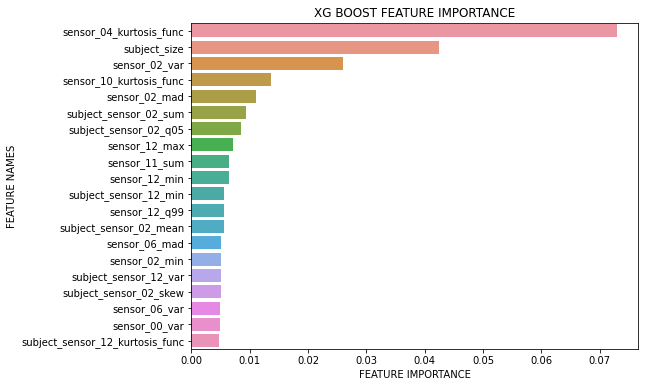

In [102]:
%%time
import seaborn as sns
import matplotlib.pyplot as plt
print('greater')
plot_feature_importance(xgb.feature_importances_,X_train.columns,'XG BOOST ', max_features = 20)

---

# 12. Baseline Model Submission File Generation

In [90]:
%%time
from sklearn.metrics import roc_auc_score
preds = xgb.predict_proba(tst_merge_data[features])[:, 1]

Wall time: 103 ms


In [94]:
%%time
sub['state'] = preds
sub.to_csv(os.path.join(work_dir, 'my_submission_041222.csv'), index = False)

Wall time: 20.9 ms


---

In [95]:
kls.submit_csv('my_submission_041222.csv', 'my_submission_041222.csv')

100%|██████████| 214k/214k [00:04<00:00, 45.7kB/s]
